In [1]:
import librosa as lb
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
recs = []
srs = []
call_types = []
df = pd.DataFrame()
#data_dir = "C:/Users/Jayde/Desktop/library/giant_otter/giant_otters/Audio_S1/"
data_dir = "C:/Users/Jayde/Desktop/library/macaques/data/train/"
for file_name in os.listdir(data_dir):
    recording, sr = lb.load(f'{data_dir}{file_name}', sr = 24414)
    #print(file)
    try:
        call_type = file_name[:2]
        recs.append(recording)
        call_types.append(call_type)
        srs.append(sr)
    except:
        #print(f"skipped {file}")
        continue
df["audio"]= recs
df["n_samples"] = [len(audio)for audio in recs]
df["type"] = call_types
print(f"processed {len(recs)} out of {len(os.listdir(data_dir))}")

processed 7285 out of 7285


In [7]:
def load_macaque_data(data_dir,slice_len=16384, batch_size= 64):
    recs = []
    call_types = []
    df = pd.DataFrame()
    for file_name in os.listdir(data_dir):
        recording, sr = lb.load(f'{data_dir}{file_name}', sr = 24414)
        try:
            call_type = file_name[:2]
            recording /= np.max(np.abs(recording))
            recs.append(recording)
            call_types.append(call_type)
        except:
            continue
    df["audio"]= recs
    df["n_samples"] = [len(audio)for audio in recs]
    df["type"] = call_types
    print(f"processed {len(recs)} out of {len(os.listdir(data_dir))}")
    df= df.loc[df["n_samples"]<=16384]
    df = df[df["type"].isin(["TH","MU","IO","AL"])]
    call_type_counts =df["type"].value_counts()
    #min_count = min(call_type_counts.values.tolist())
    min_count =960

    def sample_from_group(group):
        return group.sample(min_count, replace=True)

    # Apply the sampling function to each group
    df = df.groupby('type', group_keys=False).apply(sample_from_group)

    # Reset the index of the resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    call_type_counts = df["type"].value_counts()
    print(call_type_counts)

    n_train_data = (df.shape[0]//batch_size) *batch_size
    #audio = [centre_and_pad(signal, slice_len) for signal in df["audio"]]
    #audio = [bandpass_filter(signal,50,45000, sr) for signal in audio]
    #audio = np.array(audio)
    
    print(f"reduced to {n_train_data} training samlples")
    labels_df = pd.get_dummies(df['type'])
    labels = (labels_df.values).astype('float32')
    


    #audio = np.expand_dims(audio, axis=-1)
    return labels, labels_df

In [ ]:
labels, labels_df = load_macaque_data("C:/Users/Jayde/Desktop/library/macaques/data/train/",16384)

In [ ]:
labels

In [ ]:
labels_df

In [6]:
df.head()
print(max(df["n_samples"]))

41307


In [18]:
slice_lens = [16384, 32768, 65536]
total = len(durs)
for slice_len in slice_lens:
    dur = slice_len/24414
    count = len([i for i in durs if i<= dur])
    train_size = (count//64) *64
    percent = (train_size/total)*100
    print(f" max dur:{dur} for slice len {slice_len}. {count} recordings -> train size {train_size} ({percent} %)")

 max dur:0.6710903579913164 for slice len 16384. 6872 recordings -> train size 6848 (94.00137268359643 %)
 max dur:1.3421807159826329 for slice len 32768. 7279 recordings -> train size 7232 (99.27247769389156 %)
 max dur:2.6843614319652658 for slice len 65536. 7285 recordings -> train size 7232 (99.27247769389156 %)


In [8]:
sliced = df.loc[df["n_samples"]<=16384]

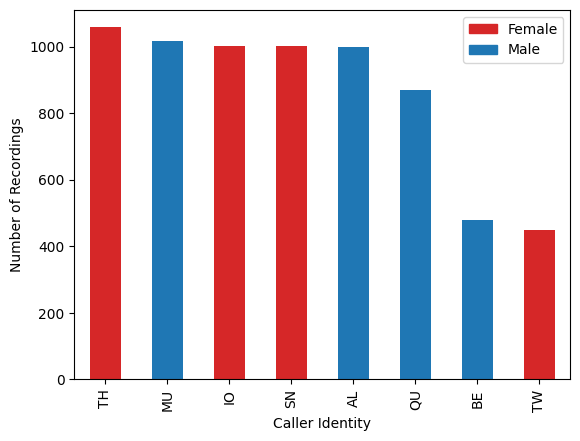

In [16]:
colours = ['tab:red','tab:blue','tab:red','tab:red','tab:blue','tab:blue','tab:blue','tab:red']
labels = ['Female','Male','Female','Female','Male','Male','Male','Female']
label_color_map = {label: color for label, color in zip(set(labels), colours)}

ax =sliced["type"].value_counts().plot.bar(color=colours)
plt.xlabel("Caller Identity")
plt.ylabel("Number of Recordings")

handles = [plt.Rectangle((0,0),1,1, color=label_color_map[label]) for label in label_color_map]
plt.legend(handles, label_color_map.keys())

fig_dir = "C:/Users/Jayde/Desktop/library/macaques/bar_under_16384.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()


In [19]:
filtered = sliced[sliced["type"].isin(["TH","MU","IO","AL"])]

In [22]:
call_type_counts =filtered["type"].value_counts()
min_count = min(call_type_counts.values.tolist())

def sample_from_group(group):
    return group.sample(min_count, replace=True)

# Apply the sampling function to each group
filtered = filtered.groupby('type', group_keys=False).apply(sample_from_group)

# Reset the index of the resulting DataFrame
filtered.reset_index(drop=True, inplace=True)
call_type_counts = filtered["type"].value_counts()
print(call_type_counts)

AL    999
IO    999
MU    999
TH    999
Name: type, dtype: int64


In [29]:
df["type"].value_counts()

TH    1345
MU    1017
IO    1002
SN    1001
AL     999
QU     975
BE     478
TW     468
Name: type, dtype: int64

In [8]:
grouped_df = df.groupby("type")
print(grouped_df["n_samples"].agg(['mean', 'std']))


              mean          std
type                           
AL     5923.216216  1955.909022
BE     2235.077406   701.751018
IO     7953.593812  3430.387484
MU     6937.176991  2190.237857
QU    13211.862564  3796.935780
SN     3764.456543   896.788813
TH    13774.805948  3767.443090
TW    10887.286325  3508.835519


In [3]:
df["dur"] = df["n_samples"]/24414

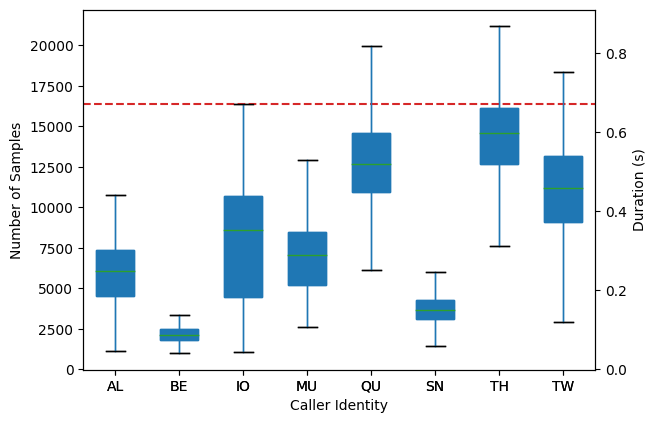

In [19]:
import seaborn as sns
fig, ax = plt.subplots()

# Create box plot
df.boxplot(column='n_samples', by='type', showfliers=False, widths=0.6, patch_artist=True, grid=False, ax=ax)
ax.set_title('')
ax.set_xlabel('Caller Identity')
ax.axhline(16384, color='tab:red', linestyle="dashed")
ax.set_ylabel('Number of Samples')

# Create secondary y-axis for the histogram
ax1 = ax.twinx()
#duration_ticks = [n_samples / 24414 for n_samples in df['n_samples']]
df.boxplot(column='dur', by='type', showfliers=False, widths=0.6, patch_artist=True, grid=False, ax=ax1)
ax1.set_title('')


# Set the y-axis label for the histogram
ax1.set_ylabel('Duration (s)')

# Adjust the position of the secondary y-axis
ax1.spines['right'].set_position(('axes', 1))
plt.suptitle('')



fig_dir = "C:/Users/Jayde/Desktop/library/macaques/box_plot.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()



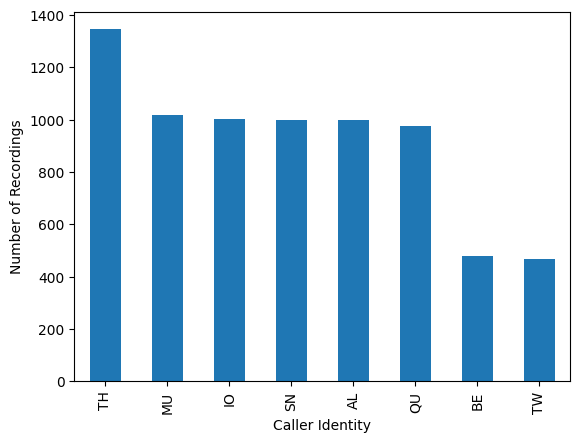

In [28]:
df["type"].value_counts().plot.bar()
plt.xlabel("Caller Identity")
plt.ylabel("Number of Recordings")
fig_dir = "C:/Users/Jayde/Desktop/library/macaques/bar_chart.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()